In [13]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import pandas as pd
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC, DiagGGNExact

plt.rcParams["figure.figsize"] = (20,10)

In [14]:
class IrisDataset(data.Dataset):
    def __init__(self, train=True):
        super(IrisDataset, self).__init__()

        iris = load_iris()

        X, y = iris.data, iris.target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

        if train:
            self.inputs, self.labels = X_train, y_train

        else:
            self.inputs, self.labels = X_test, y_test

    def __getitem__(self, index):
        inp = torch.Tensor(self.inputs[index])
        label = torch.LongTensor([self.labels[index]])
        return inp, label

    def __len__(self):
        return len(self.inputs)

dataloader = data.DataLoader(IrisDataset(train=True), batch_size=32, shuffle=True, num_workers=0)

In [16]:
def metric(inferred_tensor: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
        """Classification Accuracy
        example)
        inferred_tensor: [[0,0,1], [0,1,0]]
        ground_truth: [2, 0]
        return: 0.5
        :param inferred_tensor: (torch.Tensor) [batch_size, n_classes(3)], inferred logits
        :param ground_truth:  (torch.LongTensor) [batch_size], ground truth labels
                                each consisting LongTensor ranging from 0 to 2
        :return: (torch.Tensor) metric
        """

        inferred_tensor = torch.argmax(inferred_tensor, dim=-1)
        acc = torch.mean((inferred_tensor == ground_truth).to(torch.float), dim=-1)
        return acc

def flattenlist(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [297]:
def NN(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(4, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        #extension starts here
        torch.nn.Linear(sz, 3)
        
    )
    return(features)

def NN_deep(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(4, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        #extension starts here
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, sz),
        torch.nn.Linear(sz, 3)
        
    )
    return(features)

net = NN(sz= 512)

lossfunction = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.5)
optimizer = torch.optim.Adam(net.parameters(), lr= 0.001)

In [303]:
def train_iris(model, criterion, optim, num_epochs, device = 'cpu'):
    for epoch in range(num_epochs):
        #계산을 하기 위해서 loss를 저장하는 변수(모니터링 용)
        train_loss = torch.Tensor([0]).to(device)
        train_acc = torch.Tensor([0]).to(device)

        for x, y in dataloader:
            x = x.to(device)
            y= y.squeeze(-1).to(device)

            optimizer.zero_grad()
            y_ = model(x)

            loss = criterion(y_, y)
            train_loss +=loss
            loss.backward()
            optimizer.step()

            acc = metric(y_, y)
            train_acc += acc

        train_loss /= len(dataloader)
        train_acc /= len(dataloader)

        print('[{curr}/{tot}] >Loss: {loss:.2f}, Acc: {acc:.2f}%'.format(
            curr = epoch+1,
            tot = num_epochs,
            loss = train_loss.detach().cpu().item(),
            acc = float(100*train_acc.detach().cpu().item())
        ))




        


In [52]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

In [304]:
train_iris(net, lossfunction, optimizer, 100)

[1/100] >Loss: 0.07, Acc: 96.61%
[2/100] >Loss: 0.12, Acc: 95.31%
[3/100] >Loss: 0.07, Acc: 96.88%
[4/100] >Loss: 0.06, Acc: 96.88%
[5/100] >Loss: 0.07, Acc: 97.66%
[6/100] >Loss: 0.06, Acc: 97.66%
[7/100] >Loss: 0.07, Acc: 98.18%
[8/100] >Loss: 0.06, Acc: 97.66%
[9/100] >Loss: 0.07, Acc: 96.61%
[10/100] >Loss: 0.07, Acc: 97.40%
[11/100] >Loss: 0.07, Acc: 97.40%
[12/100] >Loss: 0.09, Acc: 95.83%
[13/100] >Loss: 0.07, Acc: 97.66%
[14/100] >Loss: 0.06, Acc: 97.40%
[15/100] >Loss: 0.08, Acc: 97.14%
[16/100] >Loss: 0.07, Acc: 96.61%
[17/100] >Loss: 0.07, Acc: 96.88%
[18/100] >Loss: 0.08, Acc: 96.61%
[19/100] >Loss: 0.07, Acc: 97.66%
[20/100] >Loss: 0.06, Acc: 97.40%
[21/100] >Loss: 0.06, Acc: 97.40%
[22/100] >Loss: 0.07, Acc: 96.09%
[23/100] >Loss: 0.06, Acc: 96.09%
[24/100] >Loss: 0.09, Acc: 97.14%
[25/100] >Loss: 0.09, Acc: 96.09%
[26/100] >Loss: 0.06, Acc: 97.40%
[27/100] >Loss: 0.08, Acc: 97.40%
[28/100] >Loss: 0.07, Acc: 95.83%
[29/100] >Loss: 0.11, Acc: 96.61%
[30/100] >Loss: 0.09, A

In [165]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=False):
    lossfunc = lossfunction

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        #print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)
    for param in model.parameters():
        print(torch.mean(param))
    
    model.eval()
    acctemp = []
    max_len = len(train_loader)
    for batch_idx, (x, y) in enumerate(train_loader):
            output = model(x)
            accuracy = get_accuracy(output, y)
            #if batch_idx % 30 == 0:
               # print(
               #     "Batch {}/{} \t".format(batch_idx, max_len) + 
               #     "Accuracy %.0f" % (accuracy * 100) + "%"
               # )
            acctemp.append(accuracy)

    print(np.mean(acctemp))
    model.train()

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):
            
            
            #if device == 'cuda':
            #    x, y = x.float().cuda(), y.long().cuda()
            #else:
            #    x, y = torch.tensor(x).float(), torch.tensor(y).float()
            #print(x, y)
            x = x.to(device)
            y= y.squeeze(-1).to(device)

            model.zero_grad()
            #x, y = x.view(-1, 1), y.view(-1, 1) 
                        
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #print(H_)
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    print()
    model.eval()
    acctemp = []
    max_len = len(train_loader)
    for batch_idx, (x, y) in enumerate(train_loader):
            output = model(x)
            accuracy = get_accuracy(output, y)
           # if batch_idx % 30 == 0:
           #     print(
           #         "Batch {}/{} \t".format(batch_idx, max_len) + 
           #         "Accuracy %.0f" % (accuracy * 100) + "%"
           #     )
            acctemp.append(accuracy)

    print(np.mean(acctemp))
    model.train()

    model.train()
    for param in model.parameters():
        print(torch.mean(param))
    
    return(Cov_diag)

In [186]:
#testnet = NN(sz=4)
testHess = get_Hessian_NN(testnet, train_loader=dataloader, prec0 = 0.1, verbose=False)

tensor(-0.0814, grad_fn=<MeanBackward0>)
tensor(0.2675, grad_fn=<MeanBackward0>)
tensor(0.0701, grad_fn=<MeanBackward0>)
tensor(0.0580, grad_fn=<MeanBackward0>)
tensor(-0.0262, grad_fn=<MeanBackward0>)
tensor(0.1605, grad_fn=<MeanBackward0>)
tensor(0.0464, grad_fn=<MeanBackward0>)
tensor(0.1622, grad_fn=<MeanBackward0>)
tensor(0.0811, grad_fn=<MeanBackward0>)
tensor(-0.0838, grad_fn=<MeanBackward0>)
tensor(-0.1204, grad_fn=<MeanBackward0>)
tensor(0.2338, grad_fn=<MeanBackward0>)
0.328125

0.3515625
tensor(-0.0814, grad_fn=<MeanBackward0>)
tensor(0.2675, grad_fn=<MeanBackward0>)
tensor(0.0701, grad_fn=<MeanBackward0>)
tensor(0.0580, grad_fn=<MeanBackward0>)
tensor(-0.0262, grad_fn=<MeanBackward0>)
tensor(0.1605, grad_fn=<MeanBackward0>)
tensor(0.0464, grad_fn=<MeanBackward0>)
tensor(0.1622, grad_fn=<MeanBackward0>)
tensor(0.0811, grad_fn=<MeanBackward0>)
tensor(-0.0838, grad_fn=<MeanBackward0>)
tensor(-0.1204, grad_fn=<MeanBackward0>)
tensor(0.2338, grad_fn=<MeanBackward0>)


## Analyze IRIS (depth: 6 hl)

### width: 1

In [24]:
#iris_state_1 = net.state_dict()

In [218]:
net = NN(sz=1)
net.load_state_dict(iris_state_1)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width1 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width1.append(torch.mean(param).item())

NameError: name 'iris_state_1' is not defined

### width: 5

In [ ]:
#iris_state_5 = net.state_dict()

In [ ]:
net = NN(sz=5)
net.load_state_dict(iris_state_5)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width5 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width5.append(torch.mean(param).item())

### width: 20

In [ ]:
#iris_state_20 = net.state_dict()

In [ ]:
net = NN(sz=20)
net.load_state_dict(iris_state_20)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width20 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width20.append(torch.mean(param).item())

### width: 100

In [ ]:
#iris_state_100 = net.state_dict()

In [ ]:
net = NN(sz=100)
net.load_state_dict(iris_state_100)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width100 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width100.append(torch.mean(param).item())

In [ ]:
line, = plt.plot(layrnames, width100)
line.set_label('100')
line, = plt.plot(layrnames, width20)
line.set_label('20')
line, = plt.plot(layrnames, width5)
line.set_label('50')
line, = plt.plot(layrnames, width1)
line.set_label('1')
plt.legend()

## depth: 10 hl

### width: 1

In [ ]:
#iris_state_1_deep = net.state_dict()

In [ ]:
net = NN_deep(sz=1)
net.load_state_dict(iris_state_1_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width1deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width1deep.append(torch.mean(param).item())

### width: 5

In [ ]:
#iris_state_5_deep = net.state_dict()

In [ ]:
net = NN_deep(sz=5)
net.load_state_dict(iris_state_5_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width5deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width5deep.append(torch.mean(param).item())

### width: 20

In [ ]:
#iris_state_20_deep = net.state_dict()

In [ ]:
net = NN_deep(sz=20)
net.load_state_dict(iris_state_20_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width20deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width20deep.append(torch.mean(param).item())

### width: 100

In [ ]:
#iris_state_100_deep = net.state_dict()

In [ ]:
net = NN_deep(sz=100)
net.load_state_dict(iris_state_100_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=dataloader, prec0=0.1, verbose=False)
width100deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width100deep.append(torch.mean(param).item())

In [ ]:
line, = plt.plot(deepnames, width100deep)
line.set_label('100')
line, = plt.plot(deepnames, width20deep)
line.set_label('20')
line, = plt.plot(deepnames, width5deep)
line.set_label('5')
line, = plt.plot(deepnames, width1deep)
line.set_label('1')
plt.legend()

In [ ]:
deepnames = []
for key in iris_state_100_deep.keys():
    if 'weight' in key:
        deepnames.append(key)
layrnames = []
for key in iris_state_100.keys():
    if 'weight' in key:
        layrnames.append(key)

In [273]:
net1 = NN(sz=1)
net2 = NN(sz=2)
net4 = NN(sz=4)
net8 = NN(sz=8)
net16 = NN(sz=16)
net32 = NN(sz=32)
net128 = NN(sz=128)

In [274]:
state1 = get_Hessian_NN(net1, train_loader = dataloader, prec0 = 0.1, verbose= False)
state2 = get_Hessian_NN(net2, train_loader = dataloader, prec0 = 0.1, verbose= False)
state4 = get_Hessian_NN(net4, train_loader = dataloader, prec0 = 0.1, verbose= False)
state8 = get_Hessian_NN(net8, train_loader = dataloader, prec0 = 0.1, verbose= False)
state16 = get_Hessian_NN(net16, train_loader = dataloader, prec0 = 0.1, verbose= False)
state32 = get_Hessian_NN(net32, train_loader = dataloader, prec0 = 0.1, verbose= False)
state128= get_Hessian_NN(net128, train_loader = dataloader, prec0 = 0.1, verbose= False)

tensor(-0.2481, grad_fn=<MeanBackward0>)
tensor(0.1636, grad_fn=<MeanBackward0>)
tensor(-0.5829, grad_fn=<MeanBackward0>)
tensor(-0.9234, grad_fn=<MeanBackward0>)
tensor(0.8947, grad_fn=<MeanBackward0>)
tensor(-0.0469, grad_fn=<MeanBackward0>)
tensor(-0.3093, grad_fn=<MeanBackward0>)
tensor(0.1873, grad_fn=<MeanBackward0>)
tensor(-0.9994, grad_fn=<MeanBackward0>)
tensor(0.2947, grad_fn=<MeanBackward0>)
tensor(0.1594, grad_fn=<MeanBackward0>)
tensor(0.1737, grad_fn=<MeanBackward0>)
0.3255208358168602

0.328125
tensor(-0.2481, grad_fn=<MeanBackward0>)
tensor(0.1636, grad_fn=<MeanBackward0>)
tensor(-0.5829, grad_fn=<MeanBackward0>)
tensor(-0.9234, grad_fn=<MeanBackward0>)
tensor(0.8947, grad_fn=<MeanBackward0>)
tensor(-0.0469, grad_fn=<MeanBackward0>)
tensor(-0.3093, grad_fn=<MeanBackward0>)
tensor(0.1873, grad_fn=<MeanBackward0>)
tensor(-0.9994, grad_fn=<MeanBackward0>)
tensor(0.2947, grad_fn=<MeanBackward0>)
tensor(0.1594, grad_fn=<MeanBackward0>)
tensor(0.1737, grad_fn=<MeanBackward0>)

In [275]:
lastlayer = []
for state in [state1, state2, state4, state8, state16, state32, state128]:
    lastl = state[-2]
    lastlayer.append(torch.mean(state[-2]).item())
print(lastlayer)
#print(lastl)

[2.7847073078155518, 2.71585750579834, 2.2160041332244873, 3.035062074661255, 2.936755895614624, 3.062570571899414, 2.923353910446167]


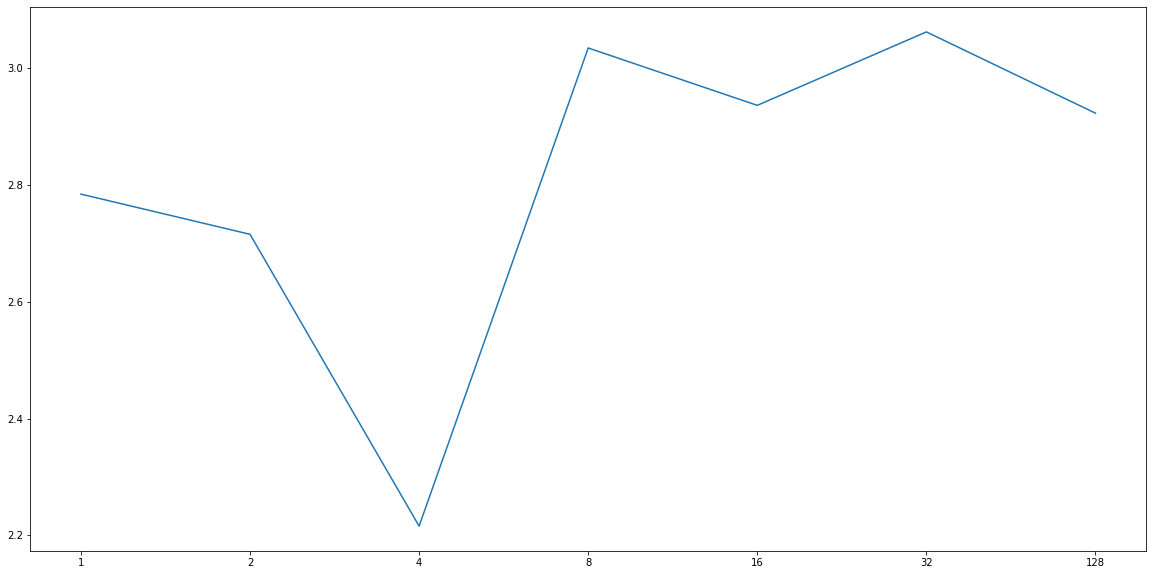

In [276]:
plt.plot(['1', '2', '4', '8', '16', '32', '128'], lastlayer)

In [219]:
dummynet = NN(sz=4)
for param in dummynet.parameters():
    print(torch.mean(param))

tensor(0.0839, grad_fn=<MeanBackward0>)
tensor(-0.0616, grad_fn=<MeanBackward0>)
tensor(-0.0010, grad_fn=<MeanBackward0>)
tensor(-0.2196, grad_fn=<MeanBackward0>)
tensor(0.0331, grad_fn=<MeanBackward0>)
tensor(-0.0530, grad_fn=<MeanBackward0>)
tensor(-0.0031, grad_fn=<MeanBackward0>)
tensor(-0.2425, grad_fn=<MeanBackward0>)
tensor(0.0655, grad_fn=<MeanBackward0>)
tensor(-0.1911, grad_fn=<MeanBackward0>)
tensor(-0.0009, grad_fn=<MeanBackward0>)
tensor(0.0570, grad_fn=<MeanBackward0>)


In [249]:
dummynet = NN(sz=4)
for param in dummynet.parameters():
    print(torch.mean(param))

tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.2148, grad_fn=<MeanBackward0>)
tensor(-0.0283, grad_fn=<MeanBackward0>)
tensor(0.1204, grad_fn=<MeanBackward0>)
tensor(-0.0268, grad_fn=<MeanBackward0>)
tensor(-0.1881, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0875, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(-0.1148, grad_fn=<MeanBackward0>)
tensor(-0.0949, grad_fn=<MeanBackward0>)
tensor(-0.1370, grad_fn=<MeanBackward0>)
